# 02 Optimising Serial Code




## Mental model of a memory

### high level view
CPU → L1 cache 
L1 filled from L2, L2 filled from L3, L3 filled from main memory
so in a closer cache = faster
cache miss = pulling from main memory!

### Cache lines and row/column-major
goal = minimise cache misses
cahce line = next chunck in array

In [ ]:
using Pkg
Pkg.activate("../") #activate the packes in the .toml files!

Julia = a column major languag! statck column after column!

In [ ]:
using BenchmarkTools
A = rand(100,100)
B = rand(100,100)
C = rand(100,100)
function inner_rows(C,A,B)
    for i in 1:100, j in 1:100
        C[i,j] = A[i,j] + B[i,j]
    end
end
@btime inner_rows(C,A,B)

So in this code, you go 1 row at a time (so i = 1, j = 1 -> 100, then i = 2...). So this is slower in Julia as it is column major!

In [ ]:
function inner_rows(C,A,B)
    for j in 1:100, i in 1:100
        C[i,j] = A[i,j] + B[i,j]
    end
end
@btime inner_rows(C,A,B)

So faster, as you go 1 column at a time now!

### Lower level view: stack and heap
stack: static allocation, size of varaiblaes known at compile time! To Heap if not
### Heap allocations and spped
heap allocations = coslty!

In [ ]:
function inner_alloc!(C,A,B)
    for j in 1:100, i in 1:100
      val = [A[i,j] + B[i,j]] #heap allocation
      C[i,j] = val[1]
    end
  end
  @btime inner_alloc!(C,A,B)

In [ ]:
function inner_noalloc!(C,A,B)
    for j in 1:100, i in 1:100
      val = A[i,j] + B[i,j] #static -> stack allocation!
      C[i,j] = val[1]
    end
  end
  @btime inner_noalloc!(C,A,B)

Float64 is allocated to stack and not heap as the size is known!

StaticArrays.jl for statically-sized arrays!!

In [ ]:
using StaticArrays
function static_inner_alloc!(C,A,B)
  for j in 1:100, i in 1:100
    val = @SVector [A[i,j] + B[i,j]]
    C[i,j] = val[1]
  end
end
@btime static_inner_alloc!(C,A,B)

### Mutation to avoid heap allocations

Preallocation of the array (cf. Wetenschappelijk programmeren!)

In [ ]:
function inner_noalloc!(C,A,B)
    for j in 1:100, i in 1:100
      val = A[i,j] + B[i,j]
      C[i,j] = val[1]
    end
  end
  @btime inner_noalloc!(C,A,B)

In [ ]:
function inner_alloc(A,B)
    C = similar(A)
    for j in 1:100, i in 1:100
      val = A[i,j] + B[i,j]
      C[i,j] = val[1]
    end
  end
  @btime inner_alloc(A,B)

### Julia's broadcasting mechanism

Array vectorisation = key!  Use `.` on an operator!

In [ ]:
A .+ B .+ C

In [ ]:
map((a,b,c)->a+b+c,A,B,C)

Fusing the operation = faster

In [ ]:
function unfused(A,B,C)
    tmp = A .+ B
    tmp .+ C
  end
  @btime unfused(A,B,C);

In [ ]:
fused(A,B,C) = A .+ B .+ C
@btime fused(A,B,C);

`.=` is also a vectorised allocation

In [ ]:
D = similar(A)
fused!(D,A,B,C) = (D .= A .+ B .+ C)
@btime fused!(D,A,B,C);

In [ ]:
D = similar(A)
non_fused!(D,A,B,C) = (D = A .+ B .+ C)
@btime non_fused!(D,A,B,C);

### note on vectorization and speed

In MATLAB/Python/R, there is a large overhead per operation. This is avoided by vectorising your code as this calls a single C function instead!
In Julia however, looping is NOT slow!! See above: generally the same speed as vectorisation!

### heap allocations from slicing

slice in Julia prodcues a COPY (so a new entity) instead of a view (which is in a way an access to the original object)

In [ ]:
A[50,50]

In [ ]:
@show A[1]
E = @view A[1:5,1:5] #view instead of default copy!
E[1] = 2.0
@show A[1] #so the value has changed now as E is not a copy of A!

### asymptotic cost of heap allocations
O(n) for arrays BUT with large constant factor

In [ ]:
using LinearAlgebra, BenchmarkTools
function alloc_timer(n)
    A = rand(n,n)
    B = rand(n,n)
    C = rand(n,n)
    t1 = @belapsed $A .* $B
    t2 = @belapsed ($C .= $A .* $B) #does have heap allocation I think
    t1,t2
end
ns = 2 .^ (2:11)
res = [alloc_timer(n) for n in ns]
alloc   = [x[1] for x in res]
noalloc = [x[2] for x in res]

using Plots
plot(ns,alloc,label="=",xscale=:log10,yscale=:log10,legend=:bottomright,
     title="Micro-optimizations matter for BLAS1")
plot!(ns,noalloc,label=".=")

### summmary
copy-paste
- Avoid cache misses by reusing values
- Iterate along columns
- Avoid heap allocations in inner loops
- Heap allocations occur when the size of things is not proven at compile-time
- Use fused broadcasts (with mutated outputs) to avoid heap allocations
- Array vectorization confers no special benefit in Julia because Julia loops are as fast as C or Fortran
- Use views instead of slices when applicable
- Avoiding heap allocations is most necessary for O(n) algorithms or algorithms with small arrays
- Use StaticArrays.jl to avoid heap allocations of small arrays in inner loops

## Julia's type inference and the compiler
Julia = JIT compiled. Wiki on jit compilation: *In computing, just-in-time (JIT) compilation (also dynamic translation or run-time compilations)[1] is compilation (of computer code) during execution of a program (at run time) rather than before execution*

2 reasons Julia is fast (covered below)

### 1: Type inference
At the core, everything has a type! 
- C: programmer has to declare the type
- Python: check the type at runtime -> overhead! variables are NOT stack-allocated, as there is no guarantee on the size!
- Julia: check the types BEFORE runtime! 

LLVM = Julia compiler https://en.wikipedia.org/wiki/LLVM

### 2: Type specializations in functions
no types provided -> generic function! but this is NOT a single function, as the function depends on the type!

In [ ]:
f(x,y) = x + y

In [ ]:
using InteractiveUtils
@code_llvm f(2,5)

So here ints are used!

In [ ]:
@code_llvm f(2.0,5.0)

While here doubles are used! This is possible because many methods are defined for the plus operator (404 as of now)

In [ ]:
mehtods_list = methods(+)
print(length(mehtods_list))


In [ ]:
@code_warntype f(2,5)

In [ ]:
@code_warntype f(2.0,5)

Now int is promoted to float64!

### type stability
Respected in above cases. It means that the outcome is known at compile time! so int + float -> ALWAYS float!

In [ ]:
function h(x,y)
    out = x + y
    rand() < 0.5 ? out : Float64(out)
  end

NOT type stable, as the output depends on this random value!

In [ ]:
@code_warntype h(2,5)

### multiple dispatch
you can tell a function how to act differently DEPENDING on the input type :)

In [ ]:
ff(x::Int,y::Int) = 2x + y
ff(x::Float64,y::Float64) = x/y
@show ff(2,5)
@show ff(2.0,5.0)

In [ ]:
methods(ff)

Abstract types in julia:

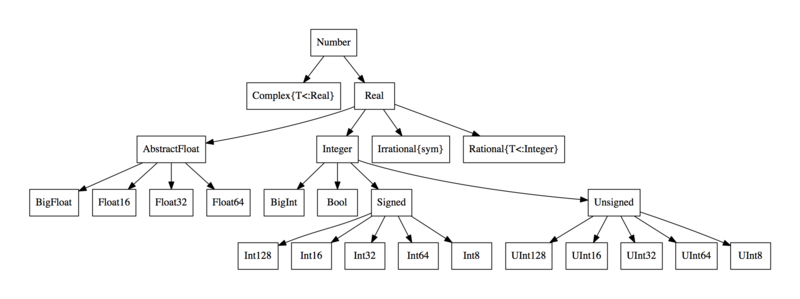

If no method exists for your input types -> MethodError!.

KEY: if types are known, the code is optimised!

### any fallabcks
Any = the maximal supertype! it falls back to all possible input values!

### ambiguities

avoid this! means that multiple methods are 'most strict' for your inputs

### untyped containers

type inference is RUINED with untyped containers

In [ ]:
a = [1.0, 2.0,3.0]

this is a typed container!

In [ ]:
b = ["1.0",2,2.0]

ANy type :( )

In [ ]:
function bad_container(a)
    a[2]
  end
@code_warntype bad_container(b)

So clear that the type inference is broken know, no idea on output of the type...
### Type definitions
#### Value types and isbits

if types can be fully inferred = value type! check with `isbits`

In [ ]:
isbits(1.0)

In [ ]:
isbits(1)

In [ ]:
struct MyComplex
    real::Float64
    imag::Float64
  end
  isbits(MyComplex(1.0,1.0))

In [ ]:
struct MyParameterizedComplex{T}
    real::T
    imag::T
end
isbits(MyParameterizedComplex(1.0,1.0))

In the way above, you don't have to specify the type!

In [ ]:
typeof(1.0f0)

In [ ]:
struct MySlowComplex
    real
    imag
end
isbits(MySlowComplex(1.0,1.0))

In [ ]:
struct MySlowComplex2
    real::AbstractFloat
    imag::AbstractFloat
end
isbits(MySlowComplex2(1.0,1.0))

Note: the number types, even ones such as Int, Float64, and Complex, are all themselves implemented in pure Julia!
Note2: isbits compiles down to bit operations from pure Julia, which means that these types can directly compile to GPU kernels through CUDAnative without modification.

### Function barriers


In [ ]:
x = Number[1.0,3] #slow container type!
function r(x)
    a = 4
    b = 2
    for i in 1:100
      c = f(x[1],a)
      d = f(b,c)
      a = f(d,x[2])
    end
    a
  end
  @btime r(x)

In [ ]:
x_fast = [1.0,3.0]
@btime r(x_fast)

Splitting up the bad container will be faster!

In [ ]:
function _s(x1,x2)
    a = 4
    b = 2
    for i in 1:100
      c = f(x1,a)
      d = f(b,c)
      a = f(d,x2)
    end
    a
end
s(x) = _s(x[1],x[2])
@btime s(x)

In [ ]:
isbits(x)#!! 

In [ ]:
@code_warntype r(x)

### specialisation at compile time

In [ ]:
function fff(x)
    if x isa Int
      y = 2
    else
      y = 4.0
    end
    x + y
  end

In [ ]:
@code_llvm fff(1)

So optimised at compile time as it KNOWS the input is an INT!

### Global scope and optimisations

so e.g. directly in REPL. Here, types cannot be inferred, as you can change the type at any time (by typing a new command)

## Overheads of individual operators

Each operation has a cost!

### Bounds checking
= what gives error if you're out of bounds! Removing this maks code faster

### SIMD
single input multiple data. E.g. adding 4 floats in 1 clock cycle!

### FMA
fused multiply-add so .e.g x*y+z is fused

### Inlining
if function call is deemed cheap enough, than combined into single call!